In [60]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, root_mean_squared_error


In [61]:
from sklearn.datasets import fetch_openml

boston = fetch_openml(name='boston', version=1, as_frame=True)
df = boston.frame

In [ ]:
df.info()
df.isnull().sum()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   CRIM     506 non-null    float64 
 1   ZN       506 non-null    float64 
 2   INDUS    506 non-null    float64 
 3   CHAS     506 non-null    category
 4   NOX      506 non-null    float64 
 5   RM       506 non-null    float64 
 6   AGE      506 non-null    float64 
 7   DIS      506 non-null    float64 
 8   RAD      506 non-null    category
 9   TAX      506 non-null    float64 
 10  PTRATIO  506 non-null    float64 
 11  B        506 non-null    float64 
 12  LSTAT    506 non-null    float64 
 13  MEDV     506 non-null    float64 
dtypes: category(2), float64(12)
memory usage: 49.0 KB


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [63]:
X = df.drop('MEDV', axis=1)
y = df['MEDV']

In [64]:
categorical_features = ['CHAS', 'RAD']
numerical_features = X.drop(columns=categorical_features).columns

In [65]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore',sparse_output=False), categorical_features)

    ]
)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [67]:
lr_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

lr_r2 = r2_score(y_test, y_pred_lr)


In [68]:
ridge_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', Ridge(alpha=1.0))
])

ridge_pipeline.fit(X_train, y_train)
y_pred_ridge = ridge_pipeline.predict(X_test)

ridge_r2 = r2_score(y_test, y_pred_ridge)


In [69]:
lasso_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', Lasso(alpha=0.01))
])

lasso_pipeline.fit(X_train, y_train)
y_pred_lasso = lasso_pipeline.predict(X_test)

lasso_r2 = r2_score(y_test, y_pred_lasso)


In [70]:
rf_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=300,
        max_depth=15,
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)

rf_r2 = r2_score(y_test, y_pred_rf)
rf_rmse = root_mean_squared_error(y_test, y_pred_rf)

print("Random Forest R²:", rf_r2)
print("Random Forest RMSE:", rf_rmse)


Random Forest R²: 0.8797963322513129
Random Forest RMSE: 2.9690048342429014


In [71]:
train_r2 = rf_pipeline.score(X_train, y_train)
test_r2 = rf_pipeline.score(X_test, y_test)

print("Train R²:", train_r2)
print("Test  R²:", test_r2)


Train R²: 0.9779950665893378
Test  R²: 0.8797963322513129


In [72]:
param_grid = {
    'model__n_estimators': [200, 300],
    'model__max_depth': [10, 15],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

grid = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_

In [73]:
y_pred_best = best_model.predict(X_test)

best_r2 = r2_score(y_test, y_pred_best)
best_rmse = root_mean_squared_error(y_test, y_pred_best)

print("Tuned RF R²:", best_r2)
print("Tuned RF RMSE:", best_rmse)

Tuned RF R²: 0.884727067511798
Tuned RF RMSE: 2.9074731701847836


In [74]:
cv_scores = cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring='r2'
)

print("CV R² Mean:", cv_scores.mean())
print("CV R² Std :", cv_scores.std())


CV R² Mean: 0.8246069162192373
CV R² Std : 0.05300445831532649


In [75]:
results = pd.DataFrame({
    'Model': [
        'Linear Regression',
        'Ridge Regression',
        'Lasso Regression',
        'Random Forest',
        'Tuned Random Forest'
    ],
    'R2 Score': [
        lr_r2,
        ridge_r2,
        lasso_r2,
        rf_r2,
        best_r2
    ]
})

results


,Model,R2 Score
0,Linear Regression,0.661569
1,Ridge Regression,0.660329
2,Lasso Regression,0.659793
3,Random Forest,0.879796
4,Tuned Random Forest,0.884727


In [76]:
feature_names = (
    numerical_features.tolist() +
    list(best_model.named_steps['preprocessing']
         .named_transformers_['cat']
         .get_feature_names_out(categorical_features))
)

importances = best_model.named_steps['model'].feature_importances_

feature_importance = pd.Series(importances, index=feature_names)\
                        .sort_values(ascending=False)

feature_importance.head(10)

RM         0.492234
LSTAT      0.323652
DIS        0.055879
CRIM       0.038142
TAX        0.015766
PTRATIO    0.015723
AGE        0.014956
NOX        0.014953
B          0.012415
INDUS      0.007084
dtype: float64

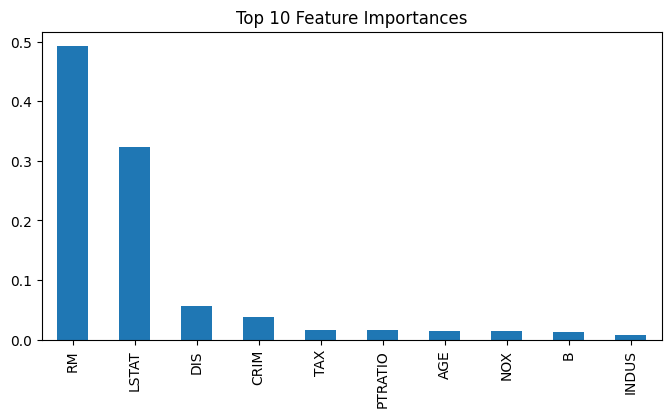

In [77]:
feature_importance.head(10).plot(kind='bar', figsize=(8,4))
plt.title("Top 10 Feature Importances")
plt.show()


In [78]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
MODEL_PATH = os.path.join(PROJECT_ROOT, "models", "best_rf_pipeline.pkl")

os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

with open(MODEL_PATH, "wb") as f:
    pickle.dump(best_model, f)

print("✅ Model saved at:", MODEL_PATH)

✅ Model saved at: c:\Users\mayur\Desktop\House_price\bostonhousepricing\models\best_rf_pipeline.pkl
